# Barycenters of stock portfolios utilizing a greedy free support OT barycenter algorith based on McCann-interpolations by Johannes von Lindheim.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cdist
from scipy.spatial import minkowski_distance
from copy import deepcopy
from sklearn.decomposition import PCA
import ot
import imageio
import itertools
import datetime
import pickle
from tqdm.notebook import tqdm
import os

The random seed is set. This ensures reproducability of the results.

In [2]:
np.set_printoptions(suppress=True, precision=5)
rng = np.random.default_rng(1000)

The next functions were written by Johannes von Lindheim with some slight modifications by me. The first two are used for the visualization of the resulting OT 
barycenters. 

In [3]:
def posns_n_nis_d(posns, heights, min_height=0.0):
    '''
    Given a positions and heights array, figure out (and make security checks for) the number of measures, number
    of support points array and dimension. Also modify posns to array, if given only one array for all measures.
    '''    
    # if given a list, we assume that we are given multiple measures and the length of the list is
    # the number of measures
    if isinstance(posns, list):
        n = len(posns)
        assert len(heights) == n, "heights needs have same length as pos (equal number of measures)"
    # if given a 2d-array and a list of of height arrays, we assume that we are given a number of measures,
    # which are all supported on the same posns-array, so the number of measures n is len(heights)
    elif isinstance(posns, np.ndarray) and posns.ndim == 2 and (isinstance(heights, list) \
                                                                or (isinstance(heights, np.ndarray) and heights.ndim == 2)):
        n = len(heights)
        posns = [posns]*n
    # if given a 3d-array and a 2d array of heights, we assume that we are given a number of measures that
    # all have the same number of points
    elif isinstance(posns, np.ndarray) and posns.ndim == 3:
        n = posns.shape[0]
        assert heights.shape[0] == n, "heights needs have same length as pos (equal number of measures)"
        assert posns.shape[1] == heights.shape[1], "number of points and number of height entries need to be the same"
        
    # if given a 2d-array and a 1d-array of heights, assume that we are given only one measure
    elif isinstance(posns, np.ndarray) and posns.ndim == 2 and isinstance(heights, np.ndarray) and heights.ndim == 1:
        n = 1
        posns = [posns]
        heights = heights[None, :]
    else:
        raise ValueError("cannot see what the number of measures is")
    assert n >= 1, "at least one measure needs to be given"
    assert all([pos.ndim == 2 for pos in posns]), "position arrays need to be two-dimenional"
    posns = [pos[height > min_height] for (pos, height) in zip(posns, heights)] # throw out points with height <= 0
    heights = [height[height > min_height] for height in heights]
    nis = np.array([pos.shape[0] for pos in posns]) # number of support points for all measures
    d = posns[0].shape[1]
    return posns, heights, n, nis, d

Following function produces a 2d plot. I added a principal component analysis (PCA) to this that is fitted to posns, which is the support of the barycenter. This ensures that the most relevant dimensions are displayed.   

In [4]:
def scatter_atomic(posns, heights, n_plots_per_col=2, scale=5, invert=False, disk_size=6000/5, xmarkers=True,
                   redxmarker_posns=None, bluexmarker_posns=None, axis_off=False, margin_fac=0.2, savepath=None, pca = False):
    '''
    Produce scatter plots for given
    
    posns: list of length n of position-arrays of shape (n_i, d), where n_i is the number of atoms in measure i
    heights: array of shape (n, n_i), where n is the total number of measures
    
    pca: True/False - determines, if a principal component analysis should be perforemed in case the dismensions
    are larger than 2.
    '''
    
    if pca:
        
        pca_values = PCA(n_components=2)
        posns = pca_values.fit_transform(posns)
        
        if redxmarker_posns is not None:
            redxmarker_posns = pca_values.transform(redxmarker_posns)
            
        if bluexmarker_posns is not None:
            bluexmarker_posns = pca_values.transform(bluexmarker_posns)            
            
    
    posns, heights, n, nis, d = posns_n_nis_d(posns, heights)
    n_plots = n
    n_rows = np.ceil(n_plots / n_plots_per_col).astype(int)
    n_cols = min(n_plots_per_col, n_plots)
    figsize = (scale*n_cols, scale*n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

    
    xmin, xmax, ymin, ymax = (min([pos[:, 0].min() for pos in posns]),
            max([pos[:, 0].max() for pos in posns]),
            min([pos[:, 1].min() for pos in posns]), 
            max([pos[:, 1].max() for pos in posns]))
    
      
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i*n_plots_per_col + j
            if idx >= n_plots or axis_off:
                ax[i, j].axis('off')
                if idx >= n_plots:
                    continue
            pos = posns[idx]
            height = heights[idx]
            
            # set plot dimensions
            xmargin = margin_fac*(xmax-xmin)
            ymargin = margin_fac*(ymax-ymin)
            #ax[i, j].set_xlim([xmin-xmargin, xmax+xmargin])
            #ax[i, j].set_ylim([ymin-ymargin, ymax+ymargin])
            ax[i, j].set_aspect('equal')
            
            # plot            
            ax[i, j].scatter(pos[:, 0], pos[:, 1], marker='o', s=height*disk_size*scale, c='gray', alpha=0.5)
            if xmarkers:
                
                ax[i, j].scatter(pos[:, 0], pos[:, 1], marker='x', c='red')
                
            if redxmarker_posns is not None:

                ax[i, j].scatter(redxmarker_posns[:, 0], redxmarker_posns[:, 1], marker='x', c='red')
            
            if bluexmarker_posns is not None:

                ax[i, j].scatter(bluexmarker_posns[:, 0], bluexmarker_posns[:, 1], marker='x', c='blue')
                

            if invert:
                ax[i, j].set_ylim(ax[i, j].get_ylim()[::-1])
                
    if savepath is not None:
        plt.savefig(savepath, dpi=300, pad_inches=0, bbox_inches='tight')

The next two functions bary_hierarchial and bary_barycost are the greedy OT barycenter algorithms.

In [5]:
def bary_hierarchical(posns, heights, weights=None, verbose=0):
    """
    Barycenter method, which iteratively merges measures using the McCann-interpolation.

    posns: Dirac positions list/array of length n. Can be given just a 2d-array, if the positions are always the same.
    heights: weights of the Dirac positions (need to sum to one)
    weights: weights of the n measures. If None is given, choose uniform weights.
    verbose: verbosity level    
    """
    
    posns, heights, n, nis, d = posns_n_nis_d(posns, heights)
    if verbose >= 1:
        print(n, nis, d)
    if weights is None:
        weights = np.ones((n,)) / n
    
    # init set of current barycenters to be the given measures
    barys_pos = deepcopy(posns)
    barys_heights = deepcopy(heights)
    barys_weights = deepcopy(weights)
    
    while len(barys_pos) > 1: # while there is still measures to merge
        
        n_new = (len(barys_pos) // 2) + (len(barys_pos) % 2)
        barys_pos_new = [None]*n_new
        barys_heights_new = [None]*n_new
        barys_weights_new = np.zeros(n_new)
        if len(barys_pos) % 2 == 1: # leave last measure unmatched, if current n is odd
            barys_pos_new[-1] = barys_pos[-1]
            barys_heights_new[-1] = barys_heights[-1]
            barys_weights_new[-1] = barys_weights[-1]
        
        for i in range(len(barys_pos) // 2): # this loop could be parallelized
            
            # compute W2 optimal transport between current barycenter and measure i
            pos0, pos1 = barys_pos[2*i], barys_pos[2*i+1]
            h0, h1 = barys_heights[2*i], barys_heights[2*i+1]
            w0, w1 = barys_weights[2*i], barys_weights[2*i+1]
            c = cdist(pos0, pos1, metric='sqeuclidean')
            pi = ot.emd(h0, h1, c)
            
            # merge them using the McCann-interpolation
            nzrows, nzcols = pi.nonzero()
            barys_pos_new[i] = w0/(w0+w1) * pos0[nzrows] + w1/(w0+w1) * pos1[nzcols]
            barys_heights_new[i] = pi[nzrows, nzcols]
            barys_weights_new[i] = w0+w1
        
        barys_pos = deepcopy(barys_pos_new)
        barys_heights = deepcopy(barys_heights_new)
        barys_weights = barys_weights_new.copy()
    
    return barys_pos[0], barys_heights[0]

Now we are going to unpack the data. That is the $\mathbb{R}^{30}$ embedding of stocks on the Korean stock market in 2016.

In [6]:
f = np.loadtxt('sentences.refined.vectors.txt', dtype = str)

STOCK_LISTINGS = f[:,0]

f = np.delete(f, 0, axis = 1).astype(float)

nr_stocks, dim = np.shape(f)

Now, we introduce some utility functions on this embedding.


In [7]:
def dist(location1, location2):
     
    distance = np.linalg.norm(location1 - location2)
    
    return distance

def dist_from_code(stock1, stock2, codes, vectors):
        
    index1 = np.where(codes == stock1)[0]
    index2 = np.where(codes == stock2)[0]
    distance = np.linalg.norm(vectors[index1,:] - vectors[index2,:])
    
    return distance    

def closest(position, codes, vectors):
    
    nr_stocks, dim = vectors.shape
    
    distances = np.zeros(nr_stocks)
    
    for i in range(nr_stocks):
        
        distances[i] = np.linalg.norm(position - vectors[i,:])
        
    index_smallest = np.where(distances == np.amin(distances))
    
    return codes[index_smallest][0], np.array(vectors[index_smallest][0])

def create_dist_matrix(vectors):
    
    n = len(vectors)
    A = np.empty((n,n), dtype = float)
    
    for i in range(n):
        
        # could use some improvements to take advantage of symmetry
        
        A[:,i] = A[i,:] = minkowski_distance(vectors[i], vectors, 2)
    
    return A


Here, we intruduce variables based on the choice of stocks we made. In our case these where:  
- LG Electronics
- Hanexpress
- SAMSUNG SDI
- KUMHO Engineering & Construction
- KIA Motors

In [17]:
# the positions of our choice of stocks.
posns = np.array([f[44,:], f[60,:], f[96,:], f[155,:], f[514,:]])

# the center of the positions of our stocks.
center = np.array([np.sum(posns, axis = 0)/(len(posns))])

# a dummy variable and the stock that is closest to the center. 
dummy, closest_center = closest(center, STOCK_LISTINGS, f)
closest_center = np.array([closest_center])

# dimension variables.
nr_pos, dim = posns.shape

Next we introduce variables for the dirichlet distribution and their results.

In [9]:
# Number of samples from distribution.
samples = 5000

# The parameter of the dirichlet distribution.
alpha = 0.001
dirichlet_para = np.ones(nr_pos)*alpha

# The resulting heights (ammount of mass in each stock) based an the dirichlet distribution.
heights = np.zeros((samples, nr_pos))

for i in range(samples):
    heights[i,:] = rng.dirichlet(dirichlet_para)

Finally, we calculate the barycenter using the greedy barcenter method.

In [10]:
# The positions of the barycenter in R^30 and the mass in each position.  
bary_pos, bary_heights = bary_hierarchical(posns, heights, verbose=0) 

Since our stocks are discrete, but the calculated barycenter has free support we now apply a nearest neighbour approach to the barycenter and save the positions of the new barycenter stocks and their weights in a dictionary. 

In [11]:
closest_stocks = {}
i = 0
for pos in bary_pos:
    code, location = closest(pos, STOCK_LISTINGS, f)
    if code in closest_stocks:
        closest_stocks[code][0] += bary_heights[i]
    else:
        closest_stocks[code] = [bary_heights[i], location]
    i += 1

We apply a principal component analysis fitted to the calculated barycenter and omit positions with very small weights to reduce clutter on the graphics. We also set some other variables that are needed for plotting.

In [12]:
stock_codes = []
for key in closest_stocks.keys():
    if closest_stocks[key][0] > 0.01:
        stock_codes.append(key)
        
print(stock_codes)
 
# Pca is fitted to free support barycenter. Yields 2 most "relevant" dimensions.
dimreduction = PCA(n_components=2)
dimreduction.fit(bary_pos)

closest_relevant_locations = np.array([closest_stocks[code][1] for code in stock_codes])

closest_relevant_locations_reduced = dimreduction.transform(closest_relevant_locations)

closest_relevant_heights = np.array([closest_stocks[code][0] for code in stock_codes])

['012450']


Here, we plot the OT barycenter before the nearest neighbour function is applied.  

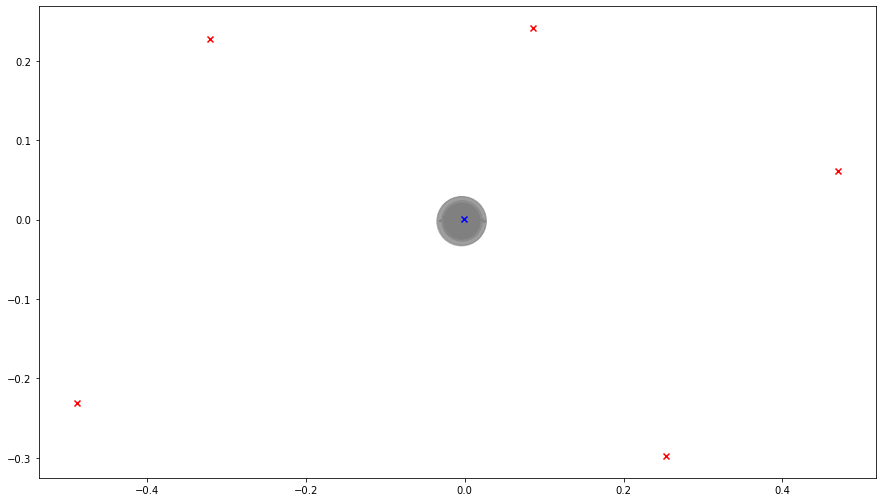

In [13]:
scatter_atomic(dimreduction.transform(bary_pos), bary_heights, xmarkers=False, pca = False, redxmarker_posns = dimreduction.transform(posns), bluexmarker_posns = dimreduction.transform(center) , scale=15, disk_size=2000)


Then the same OT barycenter with the nearest neighbour function applied.

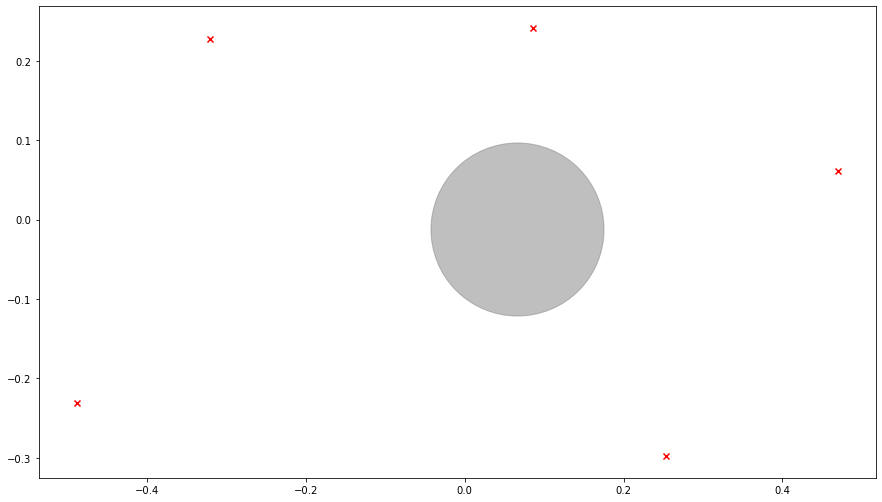

In [14]:
scatter_atomic(closest_relevant_locations_reduced, closest_relevant_heights, xmarkers=False, redxmarker_posns = dimreduction.transform(posns), scale=15, disk_size=2000)

For completeness, I also tried to calculate the discrete OT barycenter using the POT library (this algorthim uses a regularized version of OT). This was not really successful, since if the regularization parameter is chosen sufficiently small enough, the function runs into numerical issues. The problem seems the be the small mass that is given to most of the stocks by the dirichlet distribution.    

In [ ]:


M = create_dist_matrix(f)
A = np.zeros((nr_stocks, samples))

# I tried setting A to a matrix of small values, i.e. 0.001 and compensating for this in the heights 
# as well, but it unfourtunatly did not imporve performance. 

A[44,:]  = heights[:,0] 
A[60]    = heights[:,1]
A[96,:]  = heights[:,2]
A[155,:] = heights[:,3]
A[514,:] = heights[:,4]

# The last arguemnt in this function is the regularization parameter. The smaller it is the more 
# accurate the OT barycenter. It is maybe possible to interpret a trend towards the center for smaller
# and smaller values, but I would call this inconclusive. 
discrete_bary_heights = ot.bregman.barycenter_stabilized(A, M, 0.1)

# Here I get rid of the positions with the smallest mass. Otherwise the plot tries to display all outliers
# and it becomes very difficult to see anything.
for i in range(nr_stocks):
        if discrete_bary_heights[i] < 0.01:
            discrete_bary_heights[i] = 0




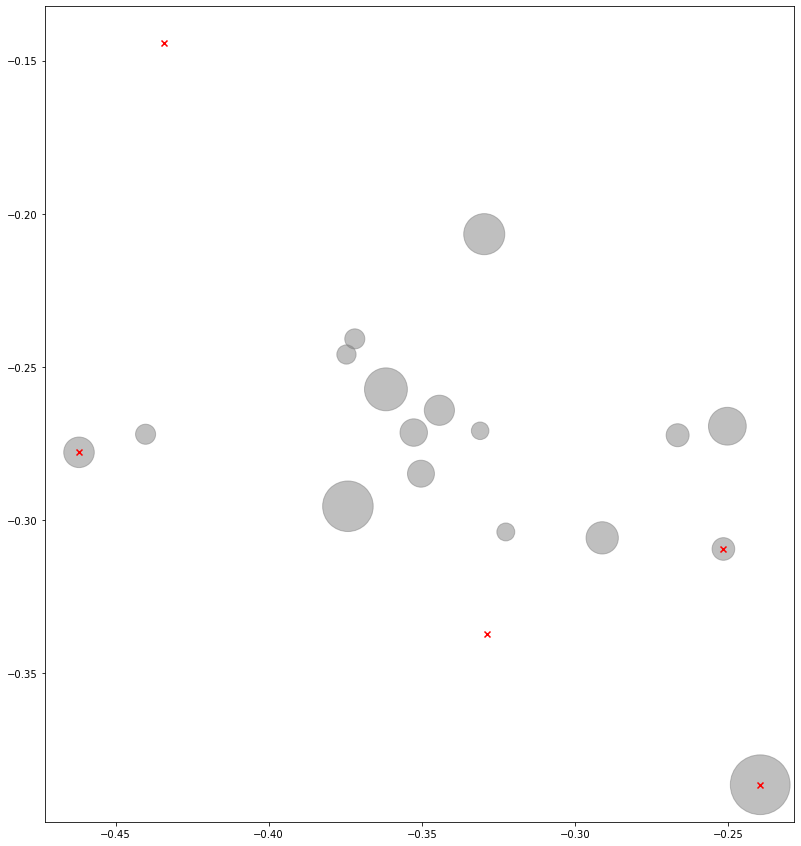

In [16]:
scatter_atomic(f, discrete_bary_heights, xmarkers=False, pca = True, redxmarker_posns = posns, scale=15, disk_size=2000)